In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.cm as cm



def get_corruption_list(dataset):

    if dataset == 'cifar':
    
        Corruptions_list = ['brightness','contrast','defocus_blur','elastic_transform',
                'fog','frost','gaussian_blur','gaussian_noise','glass_blur',
                  'impulse_noise','jpeg_compression','motion_blur','pixelate','saturate',
                  'shot_noise','snow','spatter','speckle_noise','zoom_blur']
    elif dataset == 'ImageNet_C':
    
        Corruptions_list = ['brightness','contrast','defocus_blur','elastic_transform',
                'fog','frost','gaussian_noise','glass_blur',
                  'impulse_noise','jpeg_compression','motion_blur','pixelate',
                  'shot_noise','snow', 'zoom_blur']
    elif dataset == 'ImageNet_C_bar':
        Corruptions_list = ['blue_noise_sample','brownish_noise','caustic_refraction','checkerboard_cutout',
                            'cocentric_sine_waves','inverse_sparkles','perlin_noise','plasma_noise',
                            'single_frequency_greyscale','sparkles']
    elif dataset == 'ImageNet_3DCC':
        Corruptions_list = ['near_focus', 'far_focus', 'fog_3d', 'flash', 'color_quant', 'low_light',
                             'xy_motion_blur', 'z_motion_blur', 'iso_noise', 'bit_error', 'h265_abr']

    return Corruptions_list

def get_CE(csv_test,csv_base):
    resutls_test = pd.read_csv(csv_test)
    resutls_baseline = pd.read_csv(csv_base)

    Corruptions_list = resutls_test['Corruption']
    Corruptions_list = list(Corruptions_list)

    err_test = []
    err_baseline = []
    for corruption in Corruptions_list:
        
        corruption_i = Corruptions_list.index(corruption)
        for severity in range(5):
            if corruption_i == 0:
                err_test.append(100-resutls_test.loc[corruption_i,'Acc_s'+str(severity+1)])
                err_baseline.append(100-resutls_baseline.loc[corruption_i,'Acc_s'+str(severity+1)])
            else:
                err_test[severity] += 100-resutls_test.loc[corruption_i,'Acc_s'+str(severity+1)]
    for severity in range(5):
        err_test[severity] /= len(Corruptions_list)

   
    return err_test


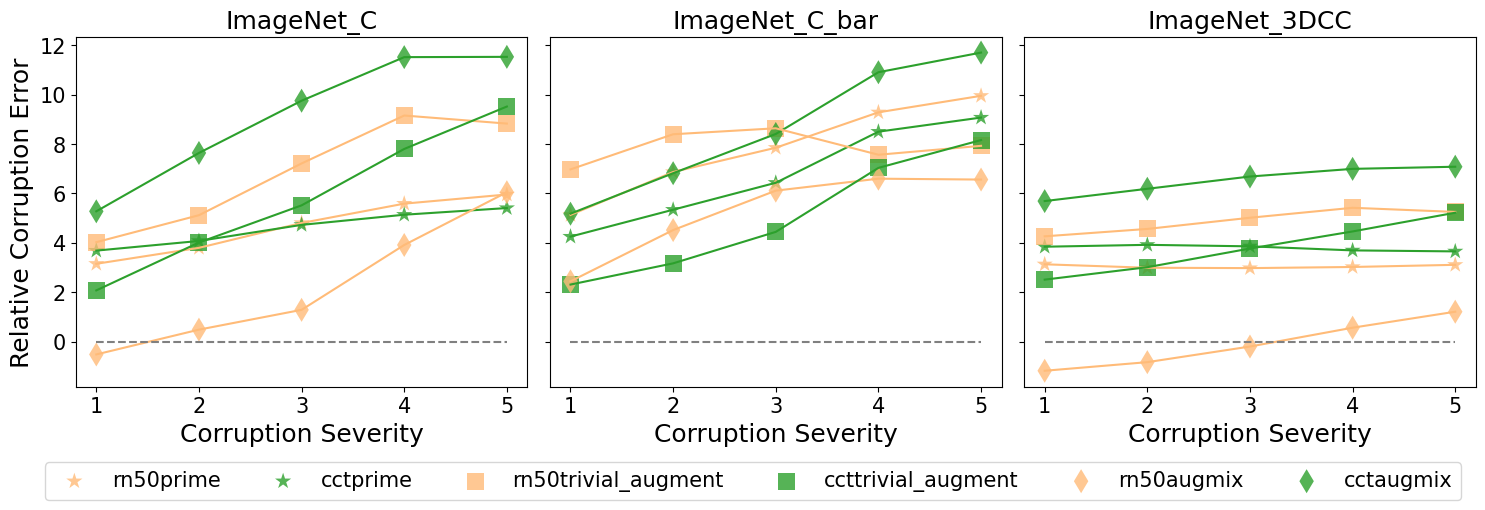

In [3]:
fig, axs = plt.subplots(1,3,sharex=True,sharey=True)
fig.set_figheight(5)
fig.set_figwidth(20)

datasets = ['ImageNet_C','ImageNet_C_bar', "ImageNet_3DCC"]

for d, dataset_i in enumerate(datasets):
    corruptions =  get_corruption_list(dataset_i)
    models = {}
    reorganize_models = {}
    models = {
        'rn50': {'model': [ 'baseline',  'prime', 'augmix','trivial_augment'], },
        'rn50dubin': {'model': [  'prime_fourier','augmix_fourier', 'trivial_augment_fourier'], },
        'cct':{'model': [  'baseline',  'prime',  'trivial_augment', 'augmix','augmix_fourier', 'prime_fourier', 'trivial_augment_fourier',], },
         }
    for m in models:

        if len(models[m].keys())<3:
            i = 4 if len(m) >4  else len(m)
            reorganize_models.update({m[:i]:{'model':[]}})

    for remodel in reorganize_models:
        for m in models:
            if remodel in m:
                for m_timm in models[m]['model']:
                    reorganize_models[remodel]['model'] += [m_timm]
                    
                    CE = get_CE('./results/summary'+dataset_i+'_'+m+m_timm+'.csv', 'results/summary'+dataset_i+'_baseline.csv')

                    if len(reorganize_models[remodel].keys())>1:
                        reorganize_models[remodel]['CE'].update({m_timm:CE}) 
                    else:   

                        reorganize_models[remodel].update({'CE':{m_timm:CE}}) 

    colors = cm.tab20(range(20))
    markers = ['o',  # circle
                '*',  # star 
                's',  # square 
                'd',  # diamond
                ]
    marker_size = [50, 150, 50, 50]
    metrics = ['CE'] 
    metrics_name = [r'$\mathrm{Classification error}$',r'$\mathrm{Accuracy}$',r'$\mathrm{ECE}$']
    model_ledgend = []

    
  
    x = [1,2,3,4,5]
    for metric_i in range(1):

        for c, model in enumerate(reorganize_models):
            for model_name in reorganize_models[model]['model']:
                if model_name == 'prime':
                    axs[d].scatter(x, 
                                y = [reorganize_models[model][metrics[metric_i]][model_name][s] - reorganize_models[model][metrics[metric_i]]['prime_fourier'][s]  for s in range(5)],
                                color=colors[c+3],  marker=markers[1], s=marker_size[1], alpha=0.8,
                                edgecolors='none',)
                
                    m = model+model_name
           
                    model_ledgend.append(m)
            
         
    #  plot comparison of TA
        for c, model in enumerate(reorganize_models):
            for model_names in reorganize_models[model]['model']:
                if model_names == 'trivial_augment':
                    axs[d].scatter(x, 
                                    y = [reorganize_models[model][metrics[metric_i]]['trivial_augment'][s] - reorganize_models[model][metrics[metric_i]]['trivial_augment_fourier'][s]  for s in range(5)],
                                color=colors[c+3],  marker=markers[2], s=marker_size[1], alpha=0.8,
                                edgecolors='none',)
                   
                    m = model+'trivial_augment'
                    model_ledgend.append(m)

                
    #  plot comparison of AugMix
        for c, model in enumerate(reorganize_models):
            
            for model_names in reorganize_models[model]['model']:
                if model_names == 'augmix' :
                    axs[d].scatter(x, 
                                   y = [reorganize_models[model][metrics[metric_i]]['augmix'][s] - reorganize_models[model][metrics[metric_i]]['augmix_fourier'][s] for s in range(5)],
                                color=colors[c+3],  marker=markers[3], s=marker_size[1], alpha=0.8,
                                edgecolors='none',)
                    
                    m = model+'augmix'
                    model_ledgend.append(m)

                
    axs[d].set_xlabel('Corruption Severity',fontsize=18)
    axs[d].set_title(dataset_i)

    axs[0].set_ylabel('Relative Corruption Error',fontsize=18)

    plt.subplots_adjust(left=0.15, bottom=0.1, right=0.85, top=0.8, wspace=0.05, hspace=2.5)
    plt.rcParams.update({'font.size': 15})

    legend = plt.legend(model_ledgend, bbox_to_anchor=(-0.6, -.27),loc = 'center',ncol=6)

    for c, model in enumerate(reorganize_models):
        for model_name in reorganize_models[model]['model']:
            if model_name == 'prime':
            
                axs[d].plot(x, 
                            [reorganize_models[model][metrics[metric_i]][model_name][s] - reorganize_models[model][metrics[metric_i]]['prime_fourier'][s]  for s in range(5)],
                            color=colors[c+3],)

                m = model+model_name
        
    #  plot comparison of AugMix
    for c, model in enumerate(reorganize_models):
        
        for model_names in reorganize_models[model]['model']:
            if model_names == 'augmix':
                axs[d].plot(x, 
                            [reorganize_models[model][metrics[metric_i]]['augmix'][s] - reorganize_models[model][metrics[metric_i]]['augmix_fourier'][s] for s in range(5)],
                            color=colors[c+3], )
                m = model+'augmix'
                

#  plot comparison of TA
    for c, model in enumerate(reorganize_models):
        for model_names in reorganize_models[model]['model']:
            if model_names == 'trivial_augment':
                
                axs[d].plot(x,  [reorganize_models[model][metrics[metric_i]]['trivial_augment'][s] - reorganize_models[model][metrics[metric_i]]['trivial_augment_fourier'][s]  for s in range(5)],
                            color=colors[c+3],                         
                )
                m = model+'trivial_augment'
    axs[d].hlines(0,xmin=1,xmax=5, colors='grey',linestyles='dashed')

plt.savefig('plot_imagenetbenchmark1'+'.pdf',bbox_inches='tight')




    

    
            
        

In [4]:
def get_avgCE(csv_test,csv_base, corruption_i):
    resutls_test = pd.read_csv(csv_test)
    resutls_baseline = pd.read_csv(csv_base)

    Corruptions_list = resutls_test['Corruption']
    Corruptions_list = list(Corruptions_list)

    err_test = []
        
    corruption_i = Corruptions_list.index(corruption_i)
    for severity in range(5):
       
        err_test.append(100-resutls_test.loc[corruption_i,'Acc_s'+str(severity+1)])
        
   
   
    return sum(err_test)/5.0


In [ ]:

datasets = ['ImageNet_C','ImageNet_C_bar', "ImageNet_3DCC"]

for d, dataset_i in enumerate(datasets):
    corruptions =  get_corruption_list(dataset_i)
    for corruption in corruptions:
        plt.figure(figsize=(8,5))
        
        models = {}
        reorganize_models = {}
        models = {
        'rn50': {'model': [ 'baseline',  'prime', 'augmix','trivial_augment'], },
        'rn50dubin': {'model': [  'prime_fourier','augmix_fourier', 'trivial_augment_fourier'], },
        'cct':{'model': [  'baseline',  'prime',  'trivial_augment', 'augmix','augmix_fourier', 'prime_fourier', 'trivial_augment_fourier',], },
         }
        
        for m in models:

            if len(models[m].keys())<3:
                i = 4 if len(m) >4  else len(m)
                reorganize_models.update({m[:i]:{'model':[]}})

        for remodel in reorganize_models:
            for m in models:
                if remodel in m:
                    for m_timm in models[m]['model']:
                        reorganize_models[remodel]['model'] += [remodel+m_timm]
                        
                        CE = get_avgCE('./results/summary'+dataset_i+'_'+m+m_timm+'.csv', 'results/summary'+dataset_i+'_baseline.csv',corruption)

                        if len(reorganize_models[remodel].keys())>1:
                            reorganize_models[remodel]['CE'].update({remodel+m_timm:CE}) 
                        else:   

                            reorganize_models[remodel].update({'CE':{remodel+m_timm:CE}}) 
 
        
    
        colors = cm.tab20(range(10))
        markers = ['o',  # circle
                    '*',  # star 
                    's',  # square 
                    'd',  # diamond

                    ]
        metrics = ['CE'] 
    
        model_ledgend = []
    
        for metric_i in range(1):       
            x = [1]
            for c, model in enumerate(reorganize_models):
                for model_names in reorganize_models[model]['model']:
                    if  'trivial_augment'  in model_names and 'fourier' not in model_names :
                        plt.scatter(model_names, 
                                        y = [reorganize_models[model][metrics[metric_i]][model_names]],
                                    color=colors[c+3],  marker=markers[0], s=marker_size[1], alpha=1,
                                    edgecolors='none',)
                        plt.plot([model_names,model_names+'_fourier'],  [reorganize_models[model][metrics[metric_i]][model_names] , reorganize_models[model][metrics[metric_i]][model_names+'_fourier']], linestyle='dashed',
                                        color=colors[c+3],                         
                            )
                    
                  
                    if  'trivial_augment_fourier' in model_names :
                        plt.scatter(model_names, 
                                        y = [reorganize_models[model][metrics[metric_i]][model_names]],
                                    color=colors[c+3],  marker=markers[0], s=marker_size[1], alpha=0.8,
                                    edgecolors='none',)

                
                    
            for c, model in enumerate(reorganize_models):
                for model_names in reorganize_models[model]['model']:
                    if  'prime'  in model_names and 'fourier' not in model_names :
                        plt.scatter(model_names, 
                                        y = [reorganize_models[model][metrics[metric_i]][model_names]],
                                    color=colors[c+3],  marker=markers[1], s=marker_size[1], alpha=1,
                                    edgecolors='none',)



                        plt.plot([model_names,model_names+'_fourier'],  [reorganize_models[model][metrics[metric_i]][model_names] , reorganize_models[model][metrics[metric_i]][model_names+'_fourier']], linestyle='dashed',
                                        color=colors[c+3],                         
                            )
                    
                    if   'prime_fourier' in model_names  :
                        plt.scatter(model_names, 
                                        y = [reorganize_models[model][metrics[metric_i]][model_names]],
                                    color=colors[c+3],  marker=markers[1], s=marker_size[1], alpha=0.8,
                                    edgecolors='none',)

                        
                       

            for c, model in enumerate(reorganize_models):
                for model_names in reorganize_models[model]['model']:
                    if  'augmix' in model_names and 'fourier' not in model_names :
                        plt.scatter(model_names, 
                                        y = [reorganize_models[model][metrics[metric_i]][model_names]],
                                    color=colors[c+3],  marker=markers[2], s=marker_size[1], alpha=1,
                                    edgecolors='none',)
                        
                        plt.plot([model_names,model_names+'_fourier'],  [reorganize_models[model][metrics[metric_i]][model_names] , reorganize_models[model][metrics[metric_i]][model_names+'_fourier']], linestyle='dashed',
                                        color=colors[c+3],                         
                            )
                 
                    if   'augmix_fourier' in  model_names :
                        plt.scatter(model_names, 
                                        y = [reorganize_models[model][metrics[metric_i]][model_names]],
                                    color=colors[c+3],  marker=markers[2], s=marker_size[1], alpha=0.8,
                                    edgecolors='none',)

                     
                    
        plt.ylim((0,100))
        plt.xticks(rotation=90,fontsize=10)
        plt.ylabel('Classification error')
        plt.title(corruption)
        plt.savefig('plt_per_corruption'+ corruption +'.pdf',bbox_inches='tight')  
            
        